In [1]:
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.checkpoint.memory import MemorySaver
from langgraph.prebuilt import ToolNode,tools_condition
from langgraph.types import interrupt,Command

from langchain.chat_models import init_chat_model
from langchain_tavily import TavilySearch

from typing import Annotated
from typing_extensions import TypedDict

from dotenv import load_dotenv
load_dotenv()

True

In [38]:
def start_session(thread_id):
    config={
        "configurable":{
            "thread_id":thread_id
        }
    }

    return config

In [16]:
class state_msg(TypedDict):
    messages:Annotated[list,add_messages]

In [17]:
groq_llm=init_chat_model("groq:llama3-8b-8192")
groq_llm

ChatGroq(client=<groq.resources.chat.completions.Completions object at 0x0000014955ECA3D0>, async_client=<groq.resources.chat.completions.AsyncCompletions object at 0x0000014955EBF5D0>, model_name='llama3-8b-8192', model_kwargs={}, groq_api_key=SecretStr('**********'))

In [112]:
tavily_search=TavilySearch(max_result=2)

In [113]:
def human_assistance(query: str) -> str:
    """ request human assistance for a query 
    whenever the user asks for any guidance or specialist of AI

    """
    human_response = interrupt({"query": query})
    return human_response["data"]

In [114]:
tools_used=[tavily_search,human_assistance]
llm_with_human_assistance=groq_llm.bind_tools(tools_used)

#### When using bind_tools(...), the only thing the model sees about your tool is:

#### the tool name (like human_assistance)

#### the docstring as a natural language description

In [115]:
def human_assistance_calling(state:state_msg):
    response= llm_with_human_assistance.invoke(
        state["messages"])
    return {"messages": [response]+state["messages"]}

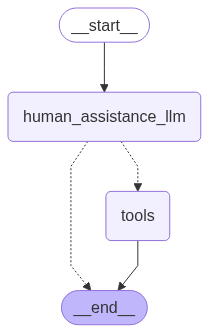

In [138]:
human_feedback_graph = StateGraph(state_msg)
memory=MemorySaver()

human_feedback_graph.add_node("human_assistance_llm",
    human_assistance_calling)
human_feedback_graph.add_node("tools",ToolNode(tools_used))

human_feedback_graph.add_edge(START, "human_assistance_llm")
human_feedback_graph.add_conditional_edges(
    "human_assistance_llm",tools_condition)
human_feedback_graph.add_edge("tools", END)

human_feedback_llm=human_feedback_graph.compile(checkpointer=memory)
human_feedback_llm

In [143]:
user_input="I need help from a real AI expert. Can you ask someone to assist me?"
config=start_session(90)

events=human_feedback_llm.invoke(
    {"messages":[user_input]},
    config=config,
    stream_mode="values"
)
print(events)
        

{'messages': [HumanMessage(content='I need help from a real AI expert. Can you ask someone to assist me?', additional_kwargs={}, response_metadata={}, id='f602ba73-7bd0-4a01-85e1-43ab084bebe7'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 't5thawjtf', 'function': {'arguments': '{"query":"I need help from a real AI expert. Can you ask someone to assist me?"}', 'name': 'human_assistance'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 82, 'prompt_tokens': 2188, 'total_tokens': 2270, 'completion_time': 0.104175824, 'prompt_time': 0.247486845, 'queue_time': 0.070268035, 'total_time': 0.351662669}, 'model_name': 'llama3-8b-8192', 'system_fingerprint': 'fp_6d1c2b0784', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--b00cde05-a234-4a7f-8cf8-4c4e836b6a39-0', tool_calls=[{'name': 'human_assistance', 'args': {'query': 'I need help from a real AI expert. Can you ask someone to assist me?'}, 'id': 't5thawjtf', 'type': 'tool_call'}], us

In [144]:
for msg in events['messages']:
    msg.pretty_print()

================================ Human Message =================================

I need help from a real AI expert. Can you ask someone to assist me?
================================== Ai Message ==================================
Tool Calls:
  human_assistance (t5thawjtf)
 Call ID: t5thawjtf
  Args:
    query: I need help from a real AI expert. Can you ask someone to assist me?


In [145]:
human_response = (
    "We, the experts are here to help! We'd recommend you check out LangGraph to build your agent."
    " It's much more reliable and extensible than simple autonomous agents."
)

human_command = Command(resume={"data": human_response})

events = human_feedback_llm.stream(human_command, config, stream_mode="values")

for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()



================================== Ai Message ==================================
Tool Calls:
  human_assistance (t5thawjtf)
 Call ID: t5thawjtf
  Args:
    query: I need help from a real AI expert. Can you ask someone to assist me?
================================= Tool Message =================================
Name: human_assistance

We, the experts are here to help! We'd recommend you check out LangGraph to build your agent. It's much more reliable and extensible than simple autonomous agents.


In [146]:
user_input="thanks  i wwant to knw the difference between langsmith adn langcgain"


events=human_feedback_llm.invoke(
    {"messages":[user_input]},
    config=config,
    stream_mode="values"
)
print(events)
        

{'messages': [HumanMessage(content='I need help from a real AI expert. Can you ask someone to assist me?', additional_kwargs={}, response_metadata={}, id='f602ba73-7bd0-4a01-85e1-43ab084bebe7'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 't5thawjtf', 'function': {'arguments': '{"query":"I need help from a real AI expert. Can you ask someone to assist me?"}', 'name': 'human_assistance'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 82, 'prompt_tokens': 2188, 'total_tokens': 2270, 'completion_time': 0.104175824, 'prompt_time': 0.247486845, 'queue_time': 0.070268035, 'total_time': 0.351662669}, 'model_name': 'llama3-8b-8192', 'system_fingerprint': 'fp_6d1c2b0784', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--b00cde05-a234-4a7f-8cf8-4c4e836b6a39-0', tool_calls=[{'name': 'human_assistance', 'args': {'query': 'I need help from a real AI expert. Can you ask someone to assist me?'}, 'id': 't5thawjtf', 'type': 'tool_call'}], us

In [147]:
for msg in events['messages']:
    msg.pretty_print()

================================ Human Message =================================

I need help from a real AI expert. Can you ask someone to assist me?
================================== Ai Message ==================================
Tool Calls:
  human_assistance (t5thawjtf)
 Call ID: t5thawjtf
  Args:
    query: I need help from a real AI expert. Can you ask someone to assist me?
================================= Tool Message =================================
Name: human_assistance

We, the experts are here to help! We'd recommend you check out LangGraph to build your agent. It's much more reliable and extensible than simple autonomous agents.
================================ Human Message =================================

thanks  i wwant to knw the difference between langsmith adn langcgain
================================== Ai Message ==================================
Tool Calls:
  tavily_search (3pfvqekm0)
 Call ID: 3pfvqekm0
  Args:
    query: difference between langsmith and lan